In [1]:
cd ..

D:\Kevin\Machine Learning\Cassava Leaf Disease Classification


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch.optim.optimizer import Optimizer
from adabelief_pytorch import AdaBelief
from ranger_adabelief import RangerAdaBelief
from warmup_scheduler import GradualWarmupScheduler

import timm

from src.dataset import get_loaders
from src.optim import get_optimizer_and_scheduler
from src.engine import get_device, get_net, train_one_epoch, valid_one_epoch
from src import config
from src.utils import *
from src.loss import FocalCosineLoss, SmoothCrossEntropyLoss, bi_tempered_logistic_loss

%matplotlib inline

In [3]:
from IPython.display import FileLinks
FileLinks(config.WEIGHTS_PATH)

Path ( /content/drive/My Drive/weights ) doesn't exist. It may still be in the process of being generated, or you may have the incorrect path.

In [4]:
class GeneralizedCassavaClassifier(nn.Module):
    def __init__(self, model_arch, n_class=5, pretrained=False):
        super().__init__()
        self.name = model_arch
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        model_list = list(self.model.children())
        model_list[-1] = nn.Linear(
            in_features=model_list[-1].in_features,
            out_features=n_class,
            bias=True
        )
        self.model = nn.Sequential(*model_list)

    def forward(self, x):
        x = self.model(x)
        return x
    
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class GradualWarmupSchedulerV2(GradualWarmupScheduler):
        def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
            super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
        def get_lr(self):
            if self.last_epoch > self.total_epoch:
                if self.after_scheduler:
                    if not self.finished:
                        self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                        self.finished = True
                    return self.after_scheduler.get_lr()
                return [base_lr * self.multiplier for base_lr in self.base_lrs]
            if self.multiplier == 1.0:
                return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
            else:
                return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


net = GeneralizedCassavaClassifier(model_arch="resnext50_32x4d")

World Size:                  1
Learning Rate Multiplier:    0.14285714285714285
Start Learning Rate:         1.4285714285714285e-05
Optimizer:                   RAdam
Scheduler:                   CosineAnnealingWarmRestarts
Gradual Warmup:              True


C:\Users\win10\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\Users\win10\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: htt

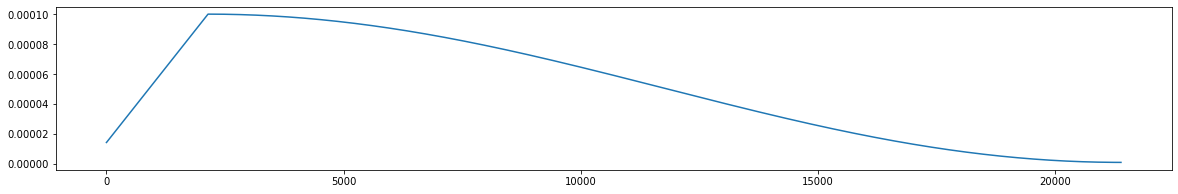

In [5]:
pull = True
fold = 0

if not pull:
    print_fn = print if not config.USE_TPU else xm.master_print
    # m = xm.xrt_world_size() if config.USE_TPU else 1
    m = 1
    print_fn(f"World Size:                  {m}")

    m /= config.WARMUP_FACTOR
    print(config.LEARNING_RATE * m)
    model     = net
    train_loader, valid_loader          = get_loaders(fold)
    optimizer = RAdam(model.parameters(), lr=config.LEARNING_RATE * m)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=5, eta_min=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=14,
                T_mult=1,
                eta_min=1e-6,
                last_epoch=-1)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#                 optimizer, T_max=5, eta_min=0)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=config.WARMUP_FACTOR, total_epoch=config.WARMUP_EPOCHS, after_scheduler=scheduler)

if pull:
    train_loader, valid_loader          = get_loaders(fold)
    optimizer, scheduler                = get_optimizer_and_scheduler(net=net, dataloader=train_loader)

lrs = []
for epoch in range(config.MAX_EPOCHS):
    for step in range(len(train_loader)):
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step(epoch + (step / len(train_loader)))
plt.rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [10]:
for lr in lrs:
    print(lr)

1.4285714285714285e-05
1.4285714285714285e-05
1.436589603100361e-05
1.4446077776292929e-05
1.4526259521582253e-05
1.4606441266871574e-05
1.4686623012160898e-05
1.4766804757450221e-05
1.4846986502739542e-05
1.4927168248028866e-05
1.5007349993318187e-05
1.508753173860751e-05
1.5167713483896834e-05
1.5247895229186155e-05
1.532807697447548e-05
1.5408258719764798e-05
1.548844046505412e-05
1.5568622210343447e-05
1.5648803955632766e-05
1.572898570092209e-05
1.580916744621141e-05
1.5889349191500734e-05
1.596953093679006e-05
1.604971268207938e-05
1.61298944273687e-05
1.6210076172658024e-05
1.6290257917947346e-05
1.637043966323667e-05
1.645062140852599e-05
1.6530803153815314e-05
1.6610984899104633e-05
1.669116664439396e-05
1.6771348389683282e-05
1.6851530134972604e-05
1.6931711880261927e-05
1.701189362555125e-05
1.7092075370840572e-05
1.7172257116129895e-05
1.7252438861419214e-05
1.733262060670854e-05
1.7412802351997863e-05
1.7492984097287182e-05
1.7573165842576508e-05
1.765334758786583e-05
1.77

9.963609644399228e-05
9.963483772467357e-05
9.963357684025571e-05
9.963231379079426e-05
9.96310485763449e-05
9.962978119696335e-05
9.962851165270548e-05
9.962723994362722e-05
9.962596606978462e-05
9.962469003123378e-05
9.962341182803095e-05
9.962213146023247e-05
9.962084892789474e-05
9.961956423107427e-05
9.961827736982766e-05
9.961698834421165e-05
9.961569715428302e-05
9.961440380009865e-05
9.961310828171557e-05
9.961181059919082e-05
9.961051075258162e-05
9.960920874194521e-05
9.960790456733901e-05
9.960659822882045e-05
9.96052897264471e-05
9.960397906027663e-05
9.960266623036679e-05
9.960135123677543e-05
9.960003407956048e-05
9.959871475878e-05
9.959739327449209e-05
9.959606962675503e-05
9.959474381562712e-05
9.959341584116678e-05
9.959208570343253e-05
9.959075340248298e-05
9.958941893837683e-05
9.958808231117289e-05
9.958674352093006e-05
9.958540256770735e-05
9.958405945156382e-05
9.958271417255865e-05
9.958136673075115e-05
9.958001712620066e-05
9.957866535896668e-05
9.9577311429108

9.581912880258418e-05
9.581494829280978e-05
9.581076578625755e-05
9.580658128311177e-05
9.580239478355681e-05
9.579820628777716e-05
9.57940157959574e-05
9.578982330828215e-05
9.578562882493618e-05
9.57814323461043e-05
9.577723387197143e-05
9.577303340272258e-05
9.576883093854282e-05
9.576462647961736e-05
9.576042002613145e-05
9.575621157827043e-05
9.575200113621977e-05
9.5747788700165e-05
9.57435742702917e-05
9.573935784678564e-05
9.573513942983254e-05
9.573091901961835e-05
9.572669661632899e-05
9.572247222015057e-05
9.571824583126918e-05
9.57140174498711e-05
9.57097870761426e-05
9.570555471027014e-05
9.570132035244018e-05
9.569708400283934e-05
9.569284566165426e-05
9.568860532907172e-05
9.568436300527855e-05
9.56801186904617e-05
9.56758723848082e-05
9.567162408850514e-05
9.566737380173973e-05
9.566312152469926e-05
9.56588672575711e-05
9.56546110005427e-05
9.565035275380163e-05
9.564609251753552e-05
9.564183029193209e-05
9.563756607717917e-05
9.563329987346463e-05
9.562903168097647e-05

8.930409691384793e-05
8.929764481762982e-05
8.929119101181518e-05
8.928473549668841e-05
8.927827827253396e-05
8.927181933963636e-05
8.926535869828023e-05
8.925889634875026e-05
8.92524322913312e-05
8.924596652630787e-05
8.923949905396522e-05
8.92330298745882e-05
8.922655898846187e-05
8.922008639587139e-05
8.921361209710197e-05
8.920713609243886e-05
8.920065838216747e-05
8.919417896657321e-05
8.918769784594158e-05
8.918121502055821e-05
8.91747304907087e-05
8.916824425667886e-05
8.916175631875443e-05
8.915526667722134e-05
8.914877533236557e-05
8.91422822844731e-05
8.913578753383009e-05
8.912929108072271e-05
8.912279292543722e-05
8.911629306825996e-05
8.910979150947735e-05
8.910328824937587e-05
8.909678328824208e-05
8.909027662636263e-05
8.908376826402422e-05
8.907725820151364e-05
8.907074643911775e-05
8.906423297712351e-05
8.905771781581789e-05
8.905120095548802e-05
8.904468239642102e-05
8.903816213890417e-05
8.903164018322476e-05
8.902511652967016e-05
8.901859117852785e-05
8.901206413008

8.182358500955568e-05
8.181553855526316e-05
8.180749072106895e-05
8.179944150732767e-05
8.1791390914394e-05
8.178333894262269e-05
8.177528559236856e-05
8.176723086398645e-05
8.175917475783131e-05
8.175111727425812e-05
8.174305841362191e-05
8.173499817627781e-05
8.172693656258101e-05
8.171887357288668e-05
8.171080920755017e-05
8.17027434669268e-05
8.1694676351372e-05
8.168660786124122e-05
8.167853799689001e-05
8.167046675867397e-05
8.166239414694874e-05
8.165432016207005e-05
8.164624480439366e-05
8.16381680742754e-05
8.16300899720712e-05
8.162201049813699e-05
8.161392965282879e-05
8.160584743650269e-05
8.15977638495148e-05
8.158967889222138e-05
8.158159256497863e-05
8.157350486814287e-05
8.15654158020705e-05
8.155732536711798e-05
8.154923356364176e-05
8.154114039199847e-05
8.153304585254464e-05
8.152494994563705e-05
8.151685267163235e-05
8.150875403088742e-05
8.150065402375905e-05
8.149255265060425e-05
8.14844499117799e-05
8.147634580764313e-05
8.146824033855098e-05
8.146013350486066e-0

7.061954058060306e-05
7.061004636097902e-05
7.060055125521705e-05
7.059105526373553e-05
7.058155838695288e-05
7.05720606252876e-05
7.056256197915819e-05
7.055306244898321e-05
7.054356203518125e-05
7.053406073817095e-05
7.052455855837096e-05
7.051505549619997e-05
7.050555155207679e-05
7.049604672642015e-05
7.048654101964892e-05
7.047703443218191e-05
7.046752696443807e-05
7.045801861683631e-05
7.044850938979563e-05
7.043899928373504e-05
7.04294882990736e-05
7.04199764362304e-05
7.041046369562458e-05
7.040095007767531e-05
7.039143558280183e-05
7.038192021142333e-05
7.037240396395916e-05
7.036288684082863e-05
7.035336884245107e-05
7.034384996924593e-05
7.033433022163267e-05
7.032480960003069e-05
7.03152881048596e-05
7.030576573653891e-05
7.029624249548823e-05
7.02867183821272e-05
7.02771933968755e-05
7.026766754015282e-05
7.025814081237895e-05
7.024861321397363e-05
7.02390847453567e-05
7.022955540694809e-05
7.022002519916761e-05
7.021049412243528e-05
7.020096217717103e-05
7.01914293637949e

5.707864136011651e-05
5.706834258173274e-05
5.705804351391861e-05
5.7047744157127966e-05
5.703744451181464e-05
5.702714457843248e-05
5.7016844357435333e-05
5.7006543849277105e-05
5.6996243054411634e-05
5.698594197329286e-05
5.697564060637469e-05
5.6965338954111036e-05
5.6955037016955825e-05
5.694473479536304e-05
5.693443228978659e-05
5.692412950068051e-05
5.691382642849872e-05
5.690352307369529e-05
5.689321943672419e-05
5.688291551803944e-05
5.687261131809509e-05
5.68623068373452e-05
5.68520020762438e-05
5.684169703524501e-05
5.683139171480285e-05
5.682108611537148e-05
5.6810780237404985e-05
5.6800474081357476e-05
5.679016764768311e-05
5.677986093683601e-05
5.676955394927037e-05
5.675924668544033e-05
5.6748939145800094e-05
5.673863133080384e-05
5.6728323240905806e-05
5.671801487656016e-05
5.670770623822119e-05
5.6697397326343094e-05
5.668708814138017e-05
5.6676778683786665e-05
5.666646895401687e-05
5.665615895252506e-05
5.664584867976554e-05
5.663553813619264e-05
5.66252273222607e-05
5

4.746778355067796e-05
4.745741232290166e-05
4.7447041229195264e-05
4.743667027001579e-05
4.742629944582023e-05
4.7415928757065564e-05
4.740555820420877e-05
4.739518778770683e-05
4.738481750801669e-05
4.7374447365595344e-05
4.7364077360899705e-05
4.735370749438675e-05
4.734333776651342e-05
4.733296817773666e-05
4.7322598728513374e-05
4.731222941930049e-05
4.730186025055495e-05
4.729149122273363e-05
4.7281122336293456e-05
4.7270753591691334e-05
4.7260384989384154e-05
4.725001652982878e-05
4.723964821348212e-05
4.7229280040801025e-05
4.7218912012242414e-05
4.720854412826308e-05
4.719817638931991e-05
4.718780879586974e-05
4.717744134836946e-05
4.716707404727584e-05
4.715670689304574e-05
4.714633988613597e-05
4.713597302700338e-05
4.712560631610475e-05
4.711523975389688e-05
4.710487334083659e-05
4.709450707738067e-05
4.708414096398587e-05
4.707377500110898e-05
4.706340918920679e-05
4.705304352873607e-05
4.704267802015354e-05
4.703231266391595e-05
4.702194746048008e-05
4.7011582410302665e-05

3.5437066529769656e-05
3.542716883015825e-05
3.5417271794722704e-05
3.540737542389914e-05
3.5397479718123623e-05
3.538758467783224e-05
3.537769030346097e-05
3.536779659544582e-05
3.535790355422275e-05
3.53480111802277e-05
3.5338119473896555e-05
3.532822843566519e-05
3.5318338065969454e-05
3.530844836524519e-05
3.529855933392812e-05
3.528867097245403e-05
3.527878328125865e-05
3.5268896260777686e-05
3.5259009911446774e-05
3.524912423370157e-05
3.523923922797767e-05
3.5229354894710676e-05
3.52194712343361e-05
3.520958824728949e-05
3.51997059340063e-05
3.518982429492205e-05
3.5179943330472096e-05
3.517006304109188e-05
3.516018342721677e-05
3.515030448928209e-05
3.514042622772315e-05
3.513054864297524e-05
3.5120671735473624e-05
3.51107955056535e-05
3.5100919953950054e-05
3.509104508079845e-05
3.508117088663386e-05
3.507129737189132e-05
3.5061424537005934e-05
3.505155238241275e-05
3.504168090854679e-05
3.5031810115842983e-05
3.5021940004736324e-05
3.501207057566172e-05
3.500220182905407e-05


2.3817794618036683e-05
2.3809043197372374e-05
2.380029295283019e-05
2.3791543884795626e-05
2.378279599365424e-05
2.3774049279791544e-05
2.3765303743592883e-05
2.375655938544368e-05
2.374781620572921e-05
2.3739074204834756e-05
2.373033338314554e-05
2.372159374104672e-05
2.3712855278923374e-05
2.3704117997160595e-05
2.369538189614337e-05
2.3686646976256633e-05
2.367791323788532e-05
2.366918068141425e-05
2.3660449307228234e-05
2.3651719115711986e-05
2.364299010725022e-05
2.3634262282227595e-05
2.3625535641028675e-05
2.3616810184037977e-05
2.3608085911640017e-05
2.359936282421921e-05
2.3590640922159925e-05
2.358192020584651e-05
2.3573200675663203e-05
2.356448233199429e-05
2.355576517522386e-05
2.3547049205736067e-05
2.3538334423914976e-05
2.3529620830144635e-05
2.3520908424808933e-05
2.3512197208291826e-05
2.3503487180977155e-05
2.3494778343248708e-05
2.3486070695490266e-05
2.347736423808549e-05
2.346865897141804e-05
2.345995489587156e-05
2.34512520118295e-05
2.3442550319675392e-05
2.34338

1.4162146698550852e-05
1.415509168852879e-05
1.4148038280024794e-05
1.4140986473349662e-05
1.413393626881413e-05
1.4126887666728838e-05
1.4119840667404411e-05
1.4112795271151356e-05
1.4105751478280114e-05
1.4098709289101094e-05
1.4091668703924552e-05
1.4084629723060809e-05
1.4077592346819975e-05
1.4070556575512157e-05
1.4063522409447418e-05
1.405648984893565e-05
1.4049458894286791e-05
1.4042429545810622e-05
1.4035401803816924e-05
1.4028375668615346e-05
1.4021351140515483e-05
1.4014328219826894e-05
1.4007306906859022e-05
1.400028720192125e-05
1.3993269105322918e-05
1.3986252617373249e-05
1.3979237738381474e-05
1.3972224468656623e-05
1.396521280850779e-05
1.3958202758243904e-05
1.3951194318173898e-05
1.3944187488606565e-05
1.3937182269850635e-05
1.3930178662214845e-05
1.3923176666007785e-05
1.3916176281537965e-05
1.3909177509113897e-05
1.3902180349043937e-05
1.3895184801636464e-05
1.388819086719967e-05
1.3881198546041783e-05
1.3874207838470885e-05
1.3867218744795045e-05
1.386023126532222

6.696700742279543e-06
6.691862164597495e-06
6.687025517296544e-06
6.682190800589795e-06
6.67735801469031e-06
6.672527159811023e-06
6.667698236164839e-06
6.662871243964493e-06
6.6580461834227024e-06
6.653223054752104e-06
6.648401858165202e-06
6.643582593874451e-06
6.638765262092178e-06
6.633949863030706e-06
6.6291363969021935e-06
6.624324863918744e-06
6.619515264292387e-06
6.614707598235039e-06
6.609901865958563e-06
6.605098067674713e-06
6.600296203595158e-06
6.5954962739315195e-06
6.590698278895255e-06
6.585902218697825e-06
6.581108093550547e-06
6.576315903664683e-06
6.571525649251389e-06
6.566737330521742e-06
6.561950947686751e-06
6.557166500957314e-06
6.552383990544249e-06
6.547603416658313e-06
6.5428247795101345e-06
6.538048079310333e-06
6.533273316269313e-06
6.52850049059753e-06
6.5237296025052775e-06
6.5189606522027904e-06
6.5141936399002035e-06
6.5094285658075596e-06
6.504665430134856e-06
6.499904233091959e-06
6.495144974888663e-06
6.490387655734708e-06
6.485632275839686e-06
6.48

2.186188876681828e-06
2.183928833996333e-06
2.1816709203314925e-06
2.179415135786798e-06
2.1771614804616432e-06
2.17490995445535e-06
2.1726605578671143e-06
2.1704132907960603e-06
2.1681681533412186e-06
2.1659251456015102e-06
2.163684267675779e-06
2.161445519662764e-06
2.159208901661118e-06
2.1569744137693982e-06
2.1547420560860526e-06
2.152511828709465e-06
2.1502837317379003e-06
2.1480577652695443e-06
2.1458339294024766e-06
2.1436122242346844e-06
2.1413926498640823e-06
2.1391752063884644e-06
2.1369598939055427e-06
2.1347467125129357e-06
2.1325356623081577e-06
2.1303267433886508e-06
2.128119955851737e-06
2.125915299794666e-06
2.123712775314573e-06
2.1215123825085325e-06
2.1193141214734813e-06
2.1171179923062952e-06
2.1149239951037477e-06
2.1127321299625107e-06
2.1105423969791646e-06
2.1083547962502067e-06
2.1061693278720243e-06
2.1039859919409386e-06
2.1018047885531226e-06
2.099625717804712e-06
2.097448779791741e-06
2.0952739746100974e-06
2.0931013023556414e-06
2.090930763124101e-06
2.0

In [7]:
len(train_loader) * 15

16035

In [4]:
df = pd.read_csv(TRAIN_FOLDS)
dataset = CassavaDataset(df=df,
                         data_root=TRAIN_IMAGES_DIR,
                         transforms=get_valid_transforms())
dataloader = DataLoader(dataset,
                        batch_size=3,
                        drop_last=False,
                        num_workers=0,
                        shuffle=False)
device = get_device(n=0)
net = get_net(name=NET, pretrained=False)
net.load_state_dict(torch.load("./generated/weights\SEResNeXt50_32x4d_BH/SEResNeXt50_32x4d_BH_fold_2_11.bin"))
net = net.to(device)

Device:                      GPU


In [6]:
preds = np.empty((0, 5), dtype=np.float64)
for images, labels in tqdm(dataloader):
    images, labels = images.to(device), labels.to(device)
    predictions = net(images).detach().cpu().numpy()
    preds = np.concatenate([preds, predictions], axis=0)
    
print(preds.shape)

KeyboardInterrupt: 

In [9]:
preds = np.empty((0, 5), dtype=np.float64)